<a href="https://colab.research.google.com/github/juanom07/tpe-teoinfo-2020/blob/master/tpe_teoinfo_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[1055, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9512, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 33839, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 53775, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 56035, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 56338, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64869, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 78567, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 94398, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 103929, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 108459, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 116314, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 185314, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 802647, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 442737, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19212]
[1092, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9629, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 34151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

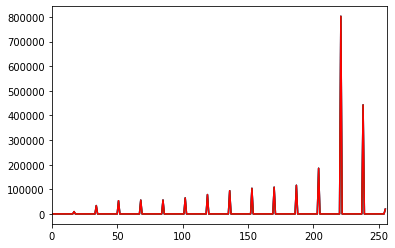

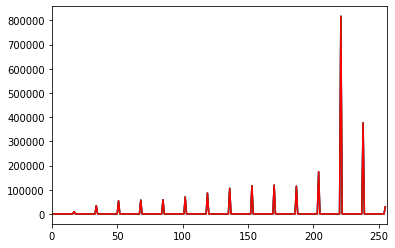

[[0.9788773]]
0.9788775174104678
0.977957237994006
0.9225582613819591
0.8207062451367302
0.9133072300614866


In [0]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import math

imgWillOriginal = cv.imread("ImagenesWill/Will(Original).bmp")
imgWill1 = cv.imread("ImagenesWill/Will_1.bmp")
imgWill2 = cv.imread("ImagenesWill/Will_2.bmp")
imgWill3 = cv.imread("ImagenesWill/Will_3.bmp")
imgWill4 = cv.imread("ImagenesWill/Will_4.bmp")
imgWill5 = cv.imread("ImagenesWill/Will_5.bmp")
imgWillCanal2 = cv.imread("ImagenesWill/Will_Canal2.bmp")
imgWillCanal8 = cv.imread("ImagenesWill/Will_Canal8.bmp")
imgWillCanal10 = cv.imread("ImagenesWill/Will_Canal10.bmp")
imgWillEj2 = cv.imread("ImagenesWill/Will_ej2.bmp")

# Genera un arreglo de 256 con la cantidad de veces que aparece ese color en la imagen
def obtener_ocurrencia_pixeles(imagen):
    result = [0] * 256
    for i in imagen:
        for j in i:
            result[j[0]] = result[j[0]] + 1

    return result

#Genera el grafico del histograma de una imagen
def obtener_histograma(imagen):
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv.calcHist([imagen],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    return plt

print(obtener_ocurrencia_pixeles(imgWillOriginal))
print(obtener_ocurrencia_pixeles(imgWill5))

hist = obtener_histograma(imgWillOriginal)
hist.show()

his2 = obtener_histograma(imgWill5)
his2.show()


def getMedia(imagen):
    media = 0
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            media += imagen[i,j,0]
    media = media/(imagen.shape[0]*imagen.shape[1])
    return media


def getDesvio(imagen, media):
    desvio = 0
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            desvio += ((imagen[i,j,0] - media) * (imagen[i,j,0] - media))
    desvio = desvio/(imagen.shape[0]*imagen.shape[1])
    return math.sqrt(desvio)

def getCorrelacionCruzada(imagenA, imagenB, mediaA, mediaB):
    sxy = 0
    for i in range(imagenA.shape[0]):
        for j in range(imagenA.shape[1]):
            sxy += ((imagenA[i,j,0] - mediaA) * (imagenB[i,j,0] - mediaB))
    sxy = sxy/(imagenA.shape[0]*imagenA.shape[1])
    return sxy

def getFactorCorrelacion(imagenA, imagenB):
    mediaA = getMedia(imagenA)
    mediaB = getMedia(imagenB)
    desvioA = getDesvio(imagenA, mediaA)
    desvioB = getDesvio(imagenB, mediaB)
    sxy = getCorrelacionCruzada(imagenA, imagenB, mediaA, mediaB)
    return sxy/(desvioA*desvioB)

res = cv.matchTemplate(imgWillOriginal,imgWill1,cv.TM_CCOEFF_NORMED)
print(res)
r = getFactorCorrelacion(imgWillOriginal, imgWill1)
print(r)
r = getFactorCorrelacion(imgWillOriginal, imgWill2)
print(r)
r = getFactorCorrelacion(imgWillOriginal, imgWill3)
print(r)
r = getFactorCorrelacion(imgWillOriginal, imgWill4)
print(r)
r = getFactorCorrelacion(imgWillOriginal, imgWill5)
print(r)